## Загрузим необходимые библиотеки

In [0]:
import joblib
import numpy as np
from collections import defaultdict
from tqdm.auto import tqdm
import pandas as pd
import copy
import joblib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np

from razdel import tokenize
from string import punctuation
punct = punctuation+'«»—…“”*–'

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Загрузим обучающие и тренировочные данные и вектора слов

In [0]:
token2vec = joblib.load("/classification/token2vec.pkl")
train_all = pd.read_csv("/classification/train.tsv", sep="\t")
test_set = pd.read_csv("/classification/test.tsv", sep="\t")

## Создадим класс модели BIMPM
Адаптация модели https://github.com/galsang/BIMPM-pytorch

In [0]:
class BIMPM(nn.Module):
    def __init__(self, 
                 embedding_tensor,
                 word_dim,
                 hidden_size, # 300
                 use_char_emb, 
                 char_dim,
                 char_vocab_size,
                 char_hidden_size,
                 class_size,
                 max_word_len, # 16
                 dropout_rate,
                 training
                ):
        super(BIMPM, self).__init__()
        
        self.word_dim = word_dim
        self.hidden_size = hidden_size
        self.char_dim = char_dim
        self.char_vocab_size = char_vocab_size
        self.char_hidden_size = char_hidden_size
        self.class_size = class_size
        self.dropout_rate = dropout_rate
        self.training = training
        self.max_word_len = max_word_len
        self.use_char_emb = use_char_emb
        self.training = training

        self.d = word_dim + char_hidden_size 
        # self.d = 200 + 200 # word_dim + char_hidden_size
        self.l = 20 # num_perspective 

        # ----- Word Representation Layer -----
        self.char_emb = nn.Embedding(char_vocab_size, char_hidden_size, padding_idx=0)
        self.word_emb = nn.Embedding.from_pretrained(embedding_tensor).to(device)
        self.word_emb.weight.requires_grad = False

        self.char_LSTM = nn.LSTM(
            input_size=char_dim,
            hidden_size=char_hidden_size,
            num_layers=1,
            bidirectional=False,
            batch_first=True)

        # ----- Context Representation Layer -----
        self.context_LSTM = nn.LSTM(
            input_size=self.d,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        # ----- Matching Layer -----
        for i in range(1, 9):
            setattr(self, f'mp_w{i}',
                    nn.Parameter(torch.rand(self.l, hidden_size)))

        # ----- Aggregation Layer -----
        self.aggregation_LSTM = nn.LSTM(
            input_size=self.l * 8,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        # ----- Prediction Layer -----
        self.pred_fc1 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.pred_fc2 = nn.Linear(hidden_size * 2, class_size)

        self.reset_parameters()

    def reset_parameters(self):
        # ----- Word Representation Layer -----
        nn.init.uniform(self.char_emb.weight, -0.005, 0.005)
        # zero vectors for padding
        self.char_emb.weight.data[0].fill_(0)

        # <unk> vectors is randomly initialized
        nn.init.uniform(self.word_emb.weight.data[0], -0.1, 0.1)

        nn.init.kaiming_normal(self.char_LSTM.weight_ih_l0)
        nn.init.constant(self.char_LSTM.bias_ih_l0, val=0)
        nn.init.orthogonal(self.char_LSTM.weight_hh_l0)
        nn.init.constant(self.char_LSTM.bias_hh_l0, val=0)

        # ----- Context Representation Layer -----
        nn.init.kaiming_normal(self.context_LSTM.weight_ih_l0)
        nn.init.constant(self.context_LSTM.bias_ih_l0, val=0)
        nn.init.orthogonal(self.context_LSTM.weight_hh_l0)
        nn.init.constant(self.context_LSTM.bias_hh_l0, val=0)

        nn.init.kaiming_normal(self.context_LSTM.weight_ih_l0_reverse)
        nn.init.constant(self.context_LSTM.bias_ih_l0_reverse, val=0)
        nn.init.orthogonal(self.context_LSTM.weight_hh_l0_reverse)
        nn.init.constant(self.context_LSTM.bias_hh_l0_reverse, val=0)

        # ----- Matching Layer -----
        for i in range(1, 9):
            w = getattr(self, f'mp_w{i}')
            nn.init.kaiming_normal(w)

        # ----- Aggregation Layer -----
        nn.init.kaiming_normal(self.aggregation_LSTM.weight_ih_l0)
        nn.init.constant(self.aggregation_LSTM.bias_ih_l0, val=0)
        nn.init.orthogonal(self.aggregation_LSTM.weight_hh_l0)
        nn.init.constant(self.aggregation_LSTM.bias_hh_l0, val=0)

        nn.init.kaiming_normal(self.aggregation_LSTM.weight_ih_l0_reverse)
        nn.init.constant(self.aggregation_LSTM.bias_ih_l0_reverse, val=0)
        nn.init.orthogonal(self.aggregation_LSTM.weight_hh_l0_reverse)
        nn.init.constant(self.aggregation_LSTM.bias_hh_l0_reverse, val=0)

        # ----- Prediction Layer ----
        nn.init.uniform(self.pred_fc1.weight, -0.005, 0.005)
        nn.init.constant(self.pred_fc1.bias, val=0)

        nn.init.uniform(self.pred_fc2.weight, -0.005, 0.005)
        nn.init.constant(self.pred_fc2.bias, val=0)

    def dropout(self, v):
        return F.dropout(v, p=self.dropout_rate, training=self.training)

    def forward(self, **kwargs):
        # ----- Matching Layer -----
        def mp_matching_func(v1, v2, w):
            """
            :param v1: (batch, seq_len, hidden_size)
            :param v2: (batch, seq_len, hidden_size) or (batch, hidden_size)
            :param w: (l, hidden_size)
            :return: (batch, l)
            """
            seq_len = v1.size(1)

            # Trick for large memory requirement
            """
            if len(v2.size()) == 2:
                v2 = torch.stack([v2] * seq_len, dim=1)

            m = []
            for i in range(self.l):
                # v1: (batch, seq_len, hidden_size)
                # v2: (batch, seq_len, hidden_size)
                # w: (1, 1, hidden_size)
                # -> (batch, seq_len)
                m.append(F.cosine_similarity(w[i].view(1, 1, -1) * v1, w[i].view(1, 1, -1) * v2, dim=2))

            # list of (batch, seq_len) -> (batch, seq_len, l)
            m = torch.stack(m, dim=2)
            """

            # (1, 1, hidden_size, l)
            w = w.transpose(1, 0).unsqueeze(0).unsqueeze(0)
            # (batch, seq_len, hidden_size, l)
            v1 = w * torch.stack([v1] * self.l, dim=3)
            if len(v2.size()) == 3:
                v2 = w * torch.stack([v2] * self.l, dim=3)
            else:
                v2 = w * torch.stack([torch.stack([v2] * seq_len, dim=1)] * self.l, dim=3)

            m = F.cosine_similarity(v1, v2, dim=2)

            return m

        def mp_matching_func_pairwise(v1, v2, w):
            """
            :param v1: (batch, seq_len1, hidden_size)
            :param v2: (batch, seq_len2, hidden_size)
            :param w: (l, hidden_size)
            :return: (batch, l, seq_len1, seq_len2)
            """

            # Trick for large memory requirement
            """
            m = []
            for i in range(self.l):
                # (1, 1, hidden_size)
                w_i = w[i].view(1, 1, -1)
                # (batch, seq_len1, hidden_size), (batch, seq_len2, hidden_size)
                v1, v2 = w_i * v1, w_i * v2
                # (batch, seq_len, hidden_size->1)
                v1_norm = v1.norm(p=2, dim=2, keepdim=True)
                v2_norm = v2.norm(p=2, dim=2, keepdim=True)

                # (batch, seq_len1, seq_len2)
                n = torch.matmul(v1, v2.permute(0, 2, 1))
                d = v1_norm * v2_norm.permute(0, 2, 1)

                m.append(div_with_small_value(n, d))

            # list of (batch, seq_len1, seq_len2) -> (batch, seq_len1, seq_len2, l)
            m = torch.stack(m, dim=3)
            """

            # (1, l, 1, hidden_size)
            w = w.unsqueeze(0).unsqueeze(2)
            # (batch, l, seq_len, hidden_size)
            v1, v2 = w * torch.stack([v1] * self.l, dim=1), w * torch.stack([v2] * self.l, dim=1)
            # (batch, l, seq_len, hidden_size->1)
            v1_norm = v1.norm(p=2, dim=3, keepdim=True)
            v2_norm = v2.norm(p=2, dim=3, keepdim=True)

            # (batch, l, seq_len1, seq_len2)
            n = torch.matmul(v1, v2.transpose(2, 3))
            d = v1_norm * v2_norm.transpose(2, 3)

            # (batch, seq_len1, seq_len2, l)
            m = div_with_small_value(n, d).permute(0, 2, 3, 1)

            return m

        def attention(v1, v2):
            """
            :param v1: (batch, seq_len1, hidden_size)
            :param v2: (batch, seq_len2, hidden_size)
            :return: (batch, seq_len1, seq_len2)
            """

            # (batch, seq_len1, 1)
            v1_norm = v1.norm(p=2, dim=2, keepdim=True)
            # (batch, 1, seq_len2)
            v2_norm = v2.norm(p=2, dim=2, keepdim=True).permute(0, 2, 1)

            # (batch, seq_len1, seq_len2)
            a = torch.bmm(v1, v2.permute(0, 2, 1))
            d = v1_norm * v2_norm

            return div_with_small_value(a, d)

        def div_with_small_value(n, d, eps=1e-8):
            # too small values are replaced by 1e-8 to prevent it from exploding.
            d = d * (d > eps).float() + eps * (d <= eps).float()
            return n / d

        # ----- Word Representation Layer -----
        # (batch, seq_len) -> (batch, seq_len, word_dim)

        p = self.word_emb(kwargs['p'])
        h = self.word_emb(kwargs['h'])

        if self.use_char_emb:
            # (batch, seq_len, max_word_len) -> (batch * seq_len, max_word_len)
            seq_len_p = kwargs['char_p'].size(1)
            seq_len_h = kwargs['char_h'].size(1)

            char_p = kwargs['char_p'].view(-1, self.max_word_len)
            char_h = kwargs['char_h'].view(-1, self.max_word_len)

            # (batch * seq_len, max_word_len, char_dim)-> (1, batch * seq_len, char_hidden_size)
            _, (char_p, _) = self.char_LSTM(self.char_emb(char_p))
            _, (char_h, _) = self.char_LSTM(self.char_emb(char_h))

            # (batch, seq_len, char_hidden_size)
            char_p = char_p.view(-1, seq_len_p, self.char_hidden_size)
            char_h = char_h.view(-1, seq_len_h, self.char_hidden_size)

            # (batch, seq_len, word_dim + char_hidden_size)
            p = torch.cat([p, char_p], dim=-1)
            h = torch.cat([h, char_h], dim=-1)

        p = self.dropout(p)
        h = self.dropout(h)

        # ----- Context Representation Layer -----
        # (batch, seq_len, hidden_size * 2)
        con_p, _ = self.context_LSTM(p)
        con_h, _ = self.context_LSTM(h)

        con_p = self.dropout(con_p)
        con_h = self.dropout(con_h)

        # (batch, seq_len, hidden_size)
        con_p_fw, con_p_bw = torch.split(con_p, self.hidden_size, dim=-1)
        con_h_fw, con_h_bw = torch.split(con_h, self.hidden_size, dim=-1)

        # 1. Full-Matching

        # (batch, seq_len, hidden_size), (batch, hidden_size)
        # -> (batch, seq_len, l)
        mv_p_full_fw = mp_matching_func(con_p_fw, con_h_fw[:, -1, :], self.mp_w1)
        mv_p_full_bw = mp_matching_func(con_p_bw, con_h_bw[:, 0, :], self.mp_w2)
        mv_h_full_fw = mp_matching_func(con_h_fw, con_p_fw[:, -1, :], self.mp_w1)
        mv_h_full_bw = mp_matching_func(con_h_bw, con_p_bw[:, 0, :], self.mp_w2)

        # 2. Maxpooling-Matching

        # (batch, seq_len1, seq_len2, l)
        mv_max_fw = mp_matching_func_pairwise(con_p_fw, con_h_fw, self.mp_w3)
        mv_max_bw = mp_matching_func_pairwise(con_p_bw, con_h_bw, self.mp_w4)

        # (batch, seq_len, l)
        mv_p_max_fw, _ = mv_max_fw.max(dim=2)
        mv_p_max_bw, _ = mv_max_bw.max(dim=2)
        mv_h_max_fw, _ = mv_max_fw.max(dim=1)
        mv_h_max_bw, _ = mv_max_bw.max(dim=1)

        # 3. Attentive-Matching

        # (batch, seq_len1, seq_len2)
        att_fw = attention(con_p_fw, con_h_fw)
        att_bw = attention(con_p_bw, con_h_bw)

        # (batch, seq_len2, hidden_size) -> (batch, 1, seq_len2, hidden_size)
        # (batch, seq_len1, seq_len2) -> (batch, seq_len1, seq_len2, 1)
        # -> (batch, seq_len1, seq_len2, hidden_size)
        att_h_fw = con_h_fw.unsqueeze(1) * att_fw.unsqueeze(3)
        att_h_bw = con_h_bw.unsqueeze(1) * att_bw.unsqueeze(3)
        # (batch, seq_len1, hidden_size) -> (batch, seq_len1, 1, hidden_size)
        # (batch, seq_len1, seq_len2) -> (batch, seq_len1, seq_len2, 1)
        # -> (batch, seq_len1, seq_len2, hidden_size)
        att_p_fw = con_p_fw.unsqueeze(2) * att_fw.unsqueeze(3)
        att_p_bw = con_p_bw.unsqueeze(2) * att_bw.unsqueeze(3)

        # (batch, seq_len1, hidden_size) / (batch, seq_len1, 1) -> (batch, seq_len1, hidden_size)
        att_mean_h_fw = div_with_small_value(att_h_fw.sum(dim=2), att_fw.sum(dim=2, keepdim=True))
        att_mean_h_bw = div_with_small_value(att_h_bw.sum(dim=2), att_bw.sum(dim=2, keepdim=True))

        # (batch, seq_len2, hidden_size) / (batch, seq_len2, 1) -> (batch, seq_len2, hidden_size)
        att_mean_p_fw = div_with_small_value(att_p_fw.sum(dim=1), att_fw.sum(dim=1, keepdim=True).permute(0, 2, 1))
        att_mean_p_bw = div_with_small_value(att_p_bw.sum(dim=1), att_bw.sum(dim=1, keepdim=True).permute(0, 2, 1))

        # (batch, seq_len, l)
        mv_p_att_mean_fw = mp_matching_func(con_p_fw, att_mean_h_fw, self.mp_w5)
        mv_p_att_mean_bw = mp_matching_func(con_p_bw, att_mean_h_bw, self.mp_w6)
        mv_h_att_mean_fw = mp_matching_func(con_h_fw, att_mean_p_fw, self.mp_w5)
        mv_h_att_mean_bw = mp_matching_func(con_h_bw, att_mean_p_bw, self.mp_w6)

        # 4. Max-Attentive-Matching

        # (batch, seq_len1, hidden_size)
        att_max_h_fw, _ = att_h_fw.max(dim=2)
        att_max_h_bw, _ = att_h_bw.max(dim=2)
        # (batch, seq_len2, hidden_size)
        att_max_p_fw, _ = att_p_fw.max(dim=1)
        att_max_p_bw, _ = att_p_bw.max(dim=1)

        # (batch, seq_len, l)
        mv_p_att_max_fw = mp_matching_func(con_p_fw, att_max_h_fw, self.mp_w7)
        mv_p_att_max_bw = mp_matching_func(con_p_bw, att_max_h_bw, self.mp_w8)
        mv_h_att_max_fw = mp_matching_func(con_h_fw, att_max_p_fw, self.mp_w7)
        mv_h_att_max_bw = mp_matching_func(con_h_bw, att_max_p_bw, self.mp_w8)

        # (batch, seq_len, l * 8)
        mv_p = torch.cat(
            [mv_p_full_fw, mv_p_max_fw, mv_p_att_mean_fw, mv_p_att_max_fw,
             mv_p_full_bw, mv_p_max_bw, mv_p_att_mean_bw, mv_p_att_max_bw], dim=2)
        mv_h = torch.cat(
            [mv_h_full_fw, mv_h_max_fw, mv_h_att_mean_fw, mv_h_att_max_fw,
             mv_h_full_bw, mv_h_max_bw, mv_h_att_mean_bw, mv_h_att_max_bw], dim=2)

        mv_p = self.dropout(mv_p)
        mv_h = self.dropout(mv_h)

        # ----- Aggregation Layer -----
        # (batch, seq_len, l * 8) -> (2, batch, hidden_size)
        _, (agg_p_last, _) = self.aggregation_LSTM(mv_p)
        _, (agg_h_last, _) = self.aggregation_LSTM(mv_h)

        # 2 * (2, batch, hidden_size) -> 2 * (batch, hidden_size * 2) -> (batch, hidden_size * 4)
        x = torch.cat(
            [agg_p_last.permute(1, 0, 2).contiguous().view(-1, self.hidden_size * 2),
             agg_h_last.permute(1, 0, 2).contiguous().view(-1, self.hidden_size * 2)], dim=1)
        x = self.dropout(x)

        # ----- Prediction Layer -----
        x = F.tanh(self.pred_fc1(x))
        x = self.dropout(x)
        x = self.pred_fc2(x)

        return x

## Подготовим вектора слов и предобработаем данные для обучения и тестирования

In [0]:
word2index = defaultdict(int)   # словарь слово-индекс
vectors = []                    # вектора слов

word2index['PAD'] = 0
vectors.append(np.zeros((1, 200))) 
    
for word, vec in token2vec.items():
    word2index[word] = len(word2index)
    vec = np.expand_dims(vec, 0)
    vectors.append(vec)
    
vectors = np.concatenate(vectors)

In [0]:
# собираем словарь символ-индекс и представляем каждое слово индексами его букв

def build_char_vocab(word2index, max_word_len = 16):
    char_vocab = {'': 0}
    characterized_words = [[0] * max_word_len, [0] * max_word_len]
    for word in word2index:
        chars = []
        for c in list(word):
            if c not in char_vocab:
                char_vocab[c] = len(char_vocab)
            chars.append(char_vocab[c])
            if len(chars) == max_word_len:
                break
        chars.extend([0] * (max_word_len - len(word)))
        characterized_words.append(chars)
    return char_vocab, characterized_words

In [0]:
# функция по подготовке батчей для тренировки символьных векторов

def characterize(batch):
    batch = batch.data.cpu().numpy().astype(int).tolist()
    return [[characterized_words[w] for w in words] for words in batch]

In [0]:
char_vocab, characterized_words = build_char_vocab(word2index)

In [0]:
# подстраиваем данные под формат нейронной сети с помощью Dataset

class Data(Dataset):
    
    def __init__(self, 
                 x1_data, 
                 x2_data, 
                 y_data, 
                 word2index, 
                 pad_token='PAD',
                 sequence_length=10, 
                 verbose=True):
        
        super().__init__()
        
        self.y_data = y_data
        
        self.word2index = word2index
        self.sequence_length = sequence_length
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        
        self.x1 = self.load(x1_data, verbose=verbose)
        self.x2 = self.load(x2_data, verbose=verbose)
        
    @staticmethod
    def process_query(query):
        line = query.strip()
        tokens = list(tokenize(line))
        tokens = [_.text.lower() for _ in tokens]         
        tokens = [i for i in tokens if i not in punct]
        return tokens
        
    def load(self, data, verbose=True):
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)
        x = []
        for query in data_iterator:
            words = self.process_query(query)
            indexed_words = self.indexing(words)
            x.append(indexed_words)
        return x
    
    def indexing(self, tokenized_query):
        query_indices = []
        for word in tokenized_query:
            query_indices.append(self.word2index[word])
        return query_indices
            
    
    def padding(self, sequence):
        if len(sequence) > self.sequence_length:
            sequence = sequence[: self.sequence_length]
        elif len(sequence) < self.sequence_length:
            sequence += [self.pad_index for i in range(self.sequence_length-len(sequence))]
        return sequence
    
    def __len__(self):
        return len(self.x1)
    
    def __getitem__(self, idx):
        x1 = self.x1[idx]
        x1 = self.padding(x1)
        x1 = torch.Tensor(x1).long()
        
        x2 = self.x2[idx]
        x2 = self.padding(x2)
        x2 = torch.Tensor(x2).long()
        
        y = self.y_data[idx]
        
        return x1, x2, y

In [11]:
test_set.head(80)

,query,pair_id,prev_query,tag,binary_tag
0,iphone 7,0,iphone 8,2,1
1,iphone 8 plus,1,iphone 7 plus,2,1
2,детская кроватка,2,детская кровать,1,1
3,iphone 8,3,айфон 8,1,1
4,запрет на рег действия,4,запрет на регистрационные действия,1,1
...,...,...,...,...,...
75,больше детские игрушки,75,больше игрушки,1,1
76,шины на ford focus r17,76,шины на ford focus 3 r17,1,1
77,honda stepwgn тяги,77,honda stepwgn рычаг,1,1
78,байкова 10,78,байкова 14,2,1


In [0]:
train_all = train_all[train_all.source != "binary-tag-edit-dist"]

In [0]:
def tag(x):
    return 0 if (x==3 or x==0) else x 

train_all["3_class_tag"] = train_all.tag.apply(tag)
test_set["3_class_tag"] = test_set.tag.apply(tag) 

In [15]:
train_all = train_all.sample(frac=1)

dev_set = train_all[6000:]
train_set = train_all[:6000]
test_set = test_set.sample(frac=1)

train_set = train_set.reset_index(drop=True)
dev_set = dev_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

# делим данные на train, test, dev
train_data = Data(train_set["prev_query"], 
                   train_set["query"], 
                   train_set["3_class_tag"], 
                   word2index)
test_data = Data(test_set["prev_query"], 
                test_set["query"], 
                test_set["3_class_tag"], 
                word2index)
dev_data = Data(dev_set["prev_query"], 
                dev_set["query"], 
                dev_set["3_class_tag"], 
                word2index)

## Обучение

In [17]:
# обучаем на GPU
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [0]:
# функция для тестирования модели

def test(model, loader, criterion, use_char_emb=True):
    print(device)
    acc, loss, size = 0, 0, 0
    preds = []

    for s1,s2,y in loader:
        kwargs = {'p': s1.to(device), 'h': s2.to(device)}

        if use_char_emb:
            char_p = Variable(torch.LongTensor(characterize(s1.to(device)))).to(device)
            char_h = Variable(torch.LongTensor(characterize(s2.to(device)))).to(device)
            kwargs["char_p"] = char_p
            kwargs["char_h"] = char_h

        with torch.no_grad():
            pred = model(**kwargs)
            batch_loss = criterion(pred, y.long().to(device))
            loss += batch_loss.item()

        _, pred = pred.cpu().max(dim=1)
        preds.extend(list(pred))
        acc += (pred == y).sum().float()
        size += len(pred)

    acc /= size
    acc = acc.item()

    loss /= size
    loss = loss
    return preds, loss, acc

In [0]:
# основное обучение

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
vectors = torch.FloatTensor(vectors)
train_loader = DataLoader(train_data, batch_size=32, drop_last=True)
dev_loader = DataLoader(dev_data, batch_size=32, drop_last=True)
test_loader = DataLoader(test_data, batch_size=32, drop_last=True)


def train(train_loader, dev_loader, test_loader, use_char_emb=True):
    
    epochs = 20
    best_f_score = 0.3

    model = BIMPM(
        embedding_tensor = vectors,
        word_dim = 200,
        hidden_size = 256, # 300
        use_char_emb = True, # true
        char_dim = 200,
        char_vocab_size = len(char_vocab),
        char_hidden_size = 200,
        class_size = 3,
        max_word_len = 16,
        dropout_rate = 0.1,
        training = True,
    ).to(device)

    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=0.0005)
    optimizer.param_groups[0]["initial_lr"] = 0.000005
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.7)    
    criterion = nn.CrossEntropyLoss().to(device)
    
    iteration_losses = []
    epoch_train_losses = []
    epoch_test_losses = []
    accuracies = []
    f_scores = []

    model.train()
    loss, last_epoch = 0, -1
    max_test_acc = 0
    max_dev_acc = 0
    
    for n_epoch in range(epochs):
        model.train()

        progress_bar = tqdm(total=len(train_loader.dataset),desc='Epoch {}'.format(n_epoch + 1))
        train_losses = []

        for i, (s1,s2,y) in enumerate(train_loader):

            optimizer.zero_grad()
            kwargs = {'p': s1.to(device), 'h': s2.to(device)}
        
            if use_char_emb:
                char_p = Variable(torch.LongTensor(characterize(s1)))
                char_h = Variable(torch.LongTensor(characterize(s2)))
                kwargs['char_p'] = char_p.to(device)
                kwargs['char_h'] = char_h.to(device)

            pred = model(**kwargs)

            batch_loss = criterion(pred, y.long().to(device))
            loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()

            iteration_losses.append(batch_loss.item())
            train_losses.append(batch_loss.item())
            progress_bar.set_postfix(loss=np.mean(iteration_losses[-500:]))
            progress_bar.update(s1.shape[0])

        progress_bar.close()
        epoch_train_losses.append(np.mean(train_losses))

        preds, dev_loss, dev_acc = test(model, dev_loader, criterion)
        preds, test_loss, test_acc = test(model, test_loader, criterion)
        epoch_test_losses.append(test_loss)

        scheduler.step()

        print(f'train loss: {loss:.3f} / dev loss: {dev_loss:.3f} / test loss: {test_loss:.3f}'
                f' / dev acc: {dev_acc:.3f} / test acc: {test_acc:.3f}')

        if test_acc > max_test_acc:
            max_test_acc = test_acc
            best_model = copy.deepcopy(model)

        loss = 0

        print(f'max dev acc: {max_dev_acc:.3f} / max test acc: {max_test_acc:.3f}')

    return best_model, epoch_train_losses, epoch_test_losses, iteration_losses

In [31]:
# обучаем
best_model, epoch_train_losses, epoch_test_losses, iteration_losses = train(train_loader, dev_loader, test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: UserWarning: nn.init.kaiming_normal is now deprecated in fa

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


cuda

cuda
cuda
train loss: 146.719 / dev loss: 0.025 / test loss: 0.025 / dev acc: 0.578 / test acc: 0.558
max dev acc: 0.000 / max test acc: 0.558


cuda

cuda
cuda
train loss: 113.297 / dev loss: 0.020 / test loss: 0.023 / dev acc: 0.734 / test acc: 0.686
max dev acc: 0.000 / max test acc: 0.686


cuda

cuda
cuda
train loss: 88.377 / dev loss: 0.020 / test loss: 0.023 / dev acc: 0.742 / test acc: 0.696
max dev acc: 0.000 / max test acc: 0.696


cuda

cuda
cuda
train loss: 66.095 / dev loss: 0.022 / test loss: 0.026 / dev acc: 0.730 / test acc: 0.695
max dev acc: 0.000 / max test acc: 0.696


cuda

cuda
cuda
train loss: 52.446 / dev loss: 0.024 / test loss: 0.029 / dev acc: 0.727 / test acc: 0.674
max dev acc: 0.000 / max test acc: 0.696


cuda

cuda
cuda
train loss: 42.964 / dev loss: 0.022 / test loss: 0.030 / dev acc: 0.773 / test acc: 0.726
max dev acc: 0.000 / max test acc: 0.726


cuda

cuda
cuda
train loss: 32.523 / dev loss: 0.024 / test loss: 0.039 / dev acc: 0.773 / test acc: 0.702
max dev acc: 0.000 / max test acc: 0.726


cuda

cuda
cuda
train loss: 25.766 / dev loss: 0.029 / test loss: 0.046 / dev acc: 0.754 / test acc: 0.683
max dev acc: 0.000 / max test acc: 0.726


cuda

cuda
cuda
train loss: 20.339 / dev loss: 0.030 / test loss: 0.045 / dev acc: 0.746 / test acc: 0.676
max dev acc: 0.000 / max test acc: 0.726


cuda

cuda
cuda
train loss: 16.937 / dev loss: 0.029 / test loss: 0.043 / dev acc: 0.746 / test acc: 0.690
max dev acc: 0.000 / max test acc: 0.726


cuda

cuda
cuda
train loss: 14.064 / dev loss: 0.032 / test loss: 0.046 / dev acc: 0.762 / test acc: 0.673
max dev acc: 0.000 / max test acc: 0.726


cuda

cuda
cuda
train loss: 12.404 / dev loss: 0.033 / test loss: 0.051 / dev acc: 0.762 / test acc: 0.696
max dev acc: 0.000 / max test acc: 0.726


cuda

cuda
cuda
train loss: 12.110 / dev loss: 0.033 / test loss: 0.045 / dev acc: 0.746 / test acc: 0.699
max dev acc: 0.000 / max test acc: 0.726


cuda

cuda
cuda
train loss: 10.976 / dev loss: 0.033 / test loss: 0.047 / dev acc: 0.766 / test acc: 0.713
max dev acc: 0.000 / max test acc: 0.726


cuda

cuda
cuda
train loss: 7.560 / dev loss: 0.033 / test loss: 0.050 / dev acc: 0.742 / test acc: 0.699
max dev acc: 0.000 / max test acc: 0.726


cuda

cuda
cuda
train loss: 8.073 / dev loss: 0.032 / test loss: 0.052 / dev acc: 0.750 / test acc: 0.714
max dev acc: 0.000 / max test acc: 0.726


cuda

cuda
cuda
train loss: 7.187 / dev loss: 0.035 / test loss: 0.053 / dev acc: 0.762 / test acc: 0.716
max dev acc: 0.000 / max test acc: 0.726


cuda

cuda
cuda
train loss: 7.021 / dev loss: 0.036 / test loss: 0.056 / dev acc: 0.754 / test acc: 0.716
max dev acc: 0.000 / max test acc: 0.726


cuda

cuda
cuda
train loss: 6.846 / dev loss: 0.033 / test loss: 0.054 / dev acc: 0.777 / test acc: 0.711
max dev acc: 0.000 / max test acc: 0.726


cuda

cuda
cuda
train loss: 6.150 / dev loss: 0.036 / test loss: 0.052 / dev acc: 0.773 / test acc: 0.714
max dev acc: 0.000 / max test acc: 0.726


## Проверим результаты

In [42]:
preds, loss, acc = test(best_model, 
                        test_loader, 
                        criterion=nn.CrossEntropyLoss(), 
                        use_char_emb=True)

cuda


/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be com

In [0]:
preds = [int(i) for i in preds]
test_set = test_set[:672]
test_set["preds"] = preds

In [45]:
test_set.head()

,query,pair_id,prev_query,tag,binary_tag,3_class_tag,preds
0,газовая горелка ламборджини,265,юла,3,0,0,0
1,gtx 1070,8,1070ti,2,1,2,2
2,2107,127,2109,2,1,2,2
3,25024652,293,2344412,2,1,2,2
4,тонировка казань лукина,502,love avto,3,0,0,0


In [46]:
# результаты немного отличаются из-за другого разделения на train-dev
print(classification_report(test_set["3_class_tag"], test_set.preds))

              precision    recall  f1-score   support

           0       0.68      0.85      0.76       200
           1       0.75      0.69      0.72       308
           2       0.64      0.55      0.59       164

    accuracy                           0.70       672
   macro avg       0.69      0.70      0.69       672
weighted avg       0.71      0.70      0.70       672



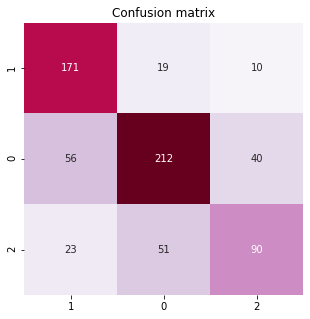

              precision    recall  f1-score   support

           0       0.68      0.85      0.76       200
           1       0.75      0.69      0.72       308
           2       0.64      0.55      0.59       164

    accuracy                           0.70       672
   macro avg       0.69      0.70      0.69       672
weighted avg       0.71      0.70      0.70       672



In [49]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

m = confusion_matrix(test_set["3_class_tag"], test_set.preds)

plt.figure(figsize = (5,5))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, xticklabels=[1,0,2], yticklabels=[1, 0, 2], cmap="PuRd")
plt.title("Confusion matrix")
plt.show()

print(classification_report(test_set["3_class_tag"], test_set.preds))